<a href="https://colab.research.google.com/github/kozz84/random/blob/main/ATMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [1] LOAD FILE AND MERGE INTO ONE DATAFRAME

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

df= pd.DataFrame()
dir='/content/drive/MyDrive/testcashmanagementdatascientisteuronet/'
for files in os.listdir(dir):
    if files.endswith(".csv"):
        temp = pd.read_csv(dir+files,sep=';',
                       parse_dates=[1],
                       index_col=[1]
                       )
        temp.rename(columns={'Withdrawal':temp['Atm'][0]},inplace=True)
        temp.drop(['Atm'],axis=1,inplace=True)
        df = pd.concat([df, temp], axis=1, join='outer')
df = df.reindex(sorted(df.columns), axis=1)

In [2]:
df.head(3)

,ATM1,ATM2,ATM3,ATM4,ATM5,ATM6,ATM7,ATM8,ATM9
ProcessDate,,,,,,,,,
2017-01-01,NaN,18200,100.0,46690.0,930.0,1400.0,NaN,117730.0,NaN
2017-01-02,31950.0,8790,10580.0,48820.0,5870.0,31120.0,14210.0,85920.0,11410.0
2017-01-03,18800.0,3620,15550.0,25520.0,2750.0,41870.0,20660.0,88720.0,14850.0


###

Some data is missing. Without backkground information it's hard to choose the imputation method.

###

In [3]:
df.isna().sum()

ATM1    151
ATM2      0
ATM3      5
ATM4      6
ATM5      4
ATM6      3
ATM7     93
ATM8     16
ATM9     86
dtype: int64

In [5]:
#df[df.isna().any(axis=1)]

In [6]:
df.fillna(method='ffill',inplace=True)
df.fillna(method='bfill',inplace=True)

In [7]:
df.isna().sum()

ATM1    0
ATM2    0
ATM3    0
ATM4    0
ATM5    0
ATM6    0
ATM7    0
ATM8    0
ATM9    0
dtype: int64

# [2] Data Analysis

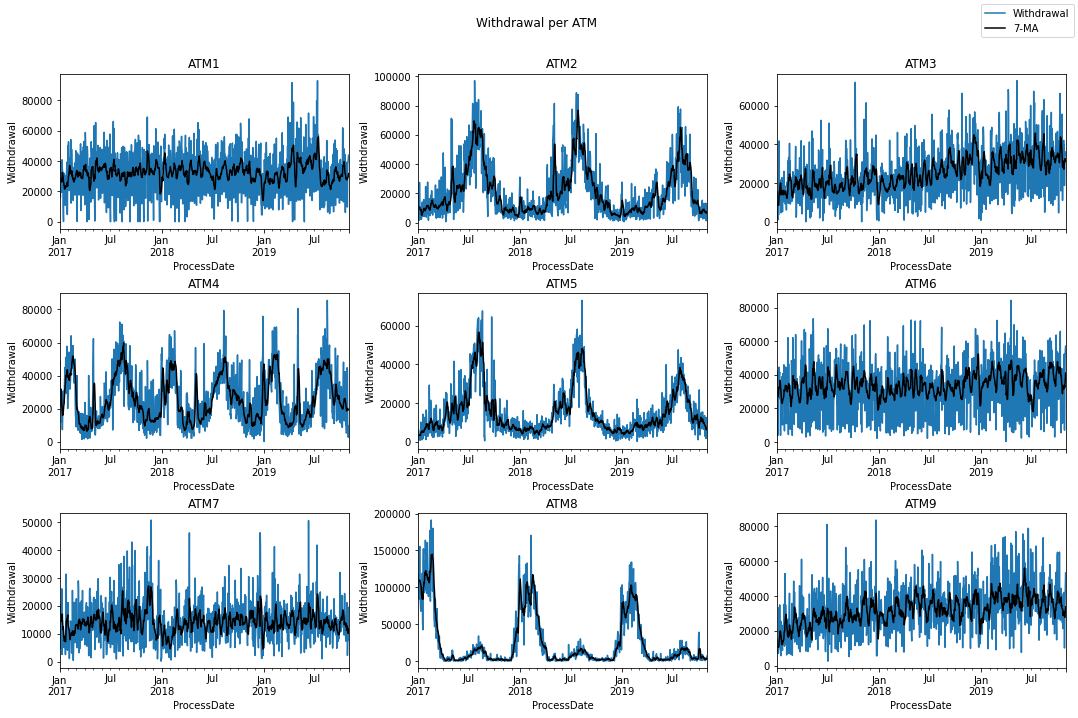

In [45]:
fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(15,10))
fig.suptitle('Withdrawal per ATM')
for i, ax in zip(df, axs.ravel()):
    df[i].plot(ax=ax,title=i)
    df[i].rolling(7).mean().plot(ax=ax,title=i,c='black')
    #plt.plot(df[i].rolling(14).mean())
    ax.set_xlabel('ProcessDate')
    ax.set_ylabel('Widthdrawal')
    #ax.set_ylim([df.min().min(), df.max().max()])
handles, labels = ax.get_legend_handles_labels()
labels = ['Withdrawal','7-MA']
fig.legend(handles, labels, loc='upper right')
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

###

ATM2, ATM4,ATM5 and ATM8 show strong annual seasonality.

ATM1, ATM6, ATM7 appear to have noconsistent trend (upward or downward) over the entire time span.

ATM3 and ATM 9 might have some upward trend.

###

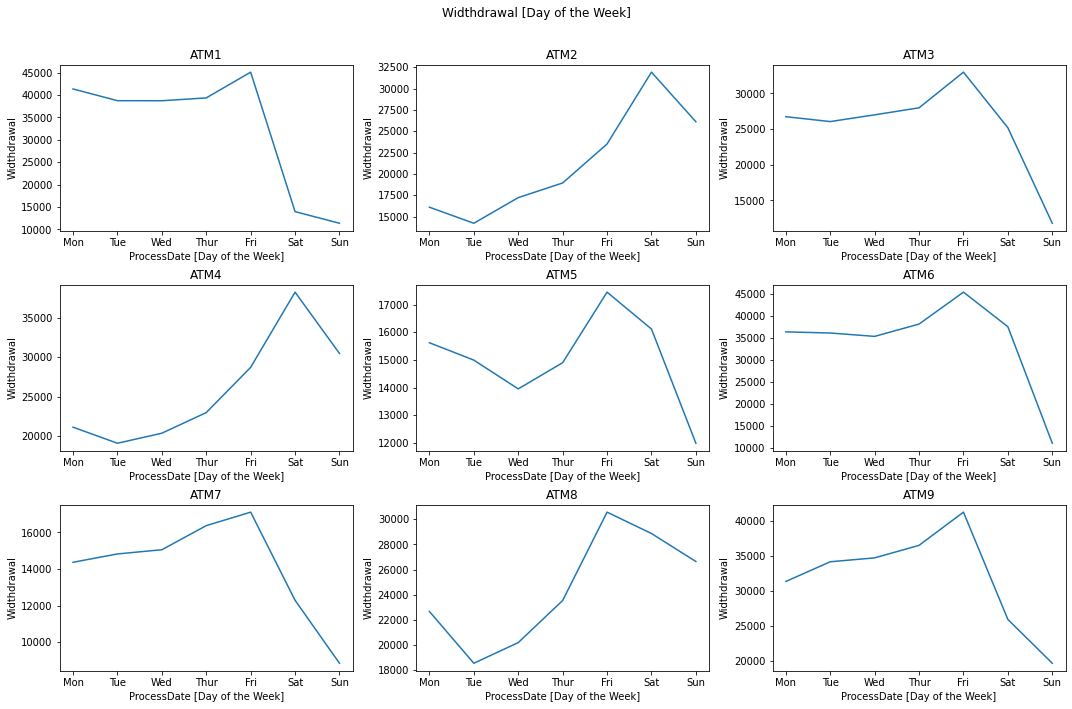

In [47]:
df_dayoftheweek = df.groupby(df.index.dayofweek).mean()
day_digit = [0,1,2,3,4,5,6]
day_word = 'Mon Tue Wed Thur Fri Sat Sun'.split()
dict_dayofweek = dict(zip(day_digit, day_word))
df_dayoftheweek =df_dayoftheweek.rename(index=dict_dayofweek)


fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(15,10))
fig.suptitle('Widthdrawal [Day of the Week]')
for i, ax in zip(df, axs.ravel()):
    df_dayoftheweek[i].plot(ax=ax,title=i)
    ax.set_xlabel('ProcessDate [Day of the Week]')
    ax.set_ylabel('Widthdrawal')
    #ax.set_ylim([df.groupby(df.index.dayofweek).mean().min().min(),df.groupby(df.index.dayofweek).mean().max().max()])
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

The vast majority of ATMs show a drop in withdrawals on Saturday and Sunday.

Biggest drop can be obsevered in order for ATM1, ATM6,ATM9.

ATM4 and ATM2 show a steady increase from Monday to Saturday.

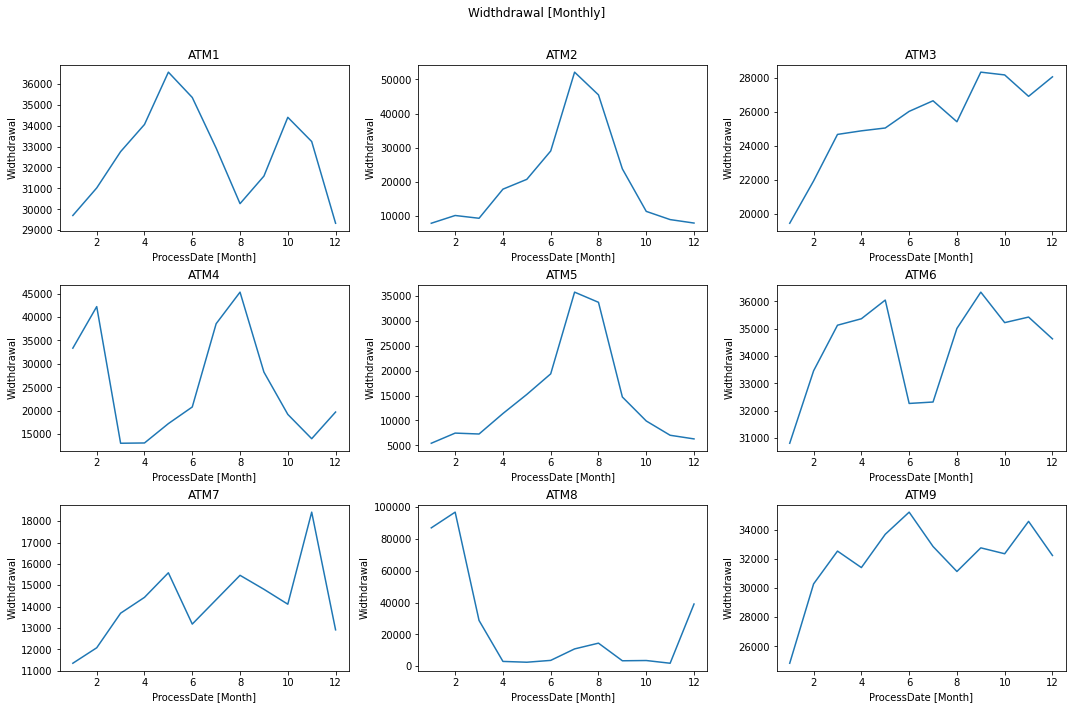

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(15,10))
fig.suptitle('Widthdrawal [Monthly]')
for i, ax in zip(df, axs.ravel()):
    df.groupby(df.index.month).mean()[i].plot(ax=ax,title=i)
    ax.set_xlabel('ProcessDate [Month]')
    ax.set_ylabel('Widthdrawal')
    #ax.set_ylim([df.groupby(df.index.month).mean().min().min(),df.groupby(df.index.month).mean().max().max()])
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

###

All ATMs show annual seasonality.

ATM2 and ATM5 show increase in withdraw in July/August.

ATM4 and ATM8 show increase in withdraw in July/August as well as December-February.

ATM3, ATM9 show a decrease in withdrawals in January.
ATM6 show decrease in withdrawals in January and June/July.

###


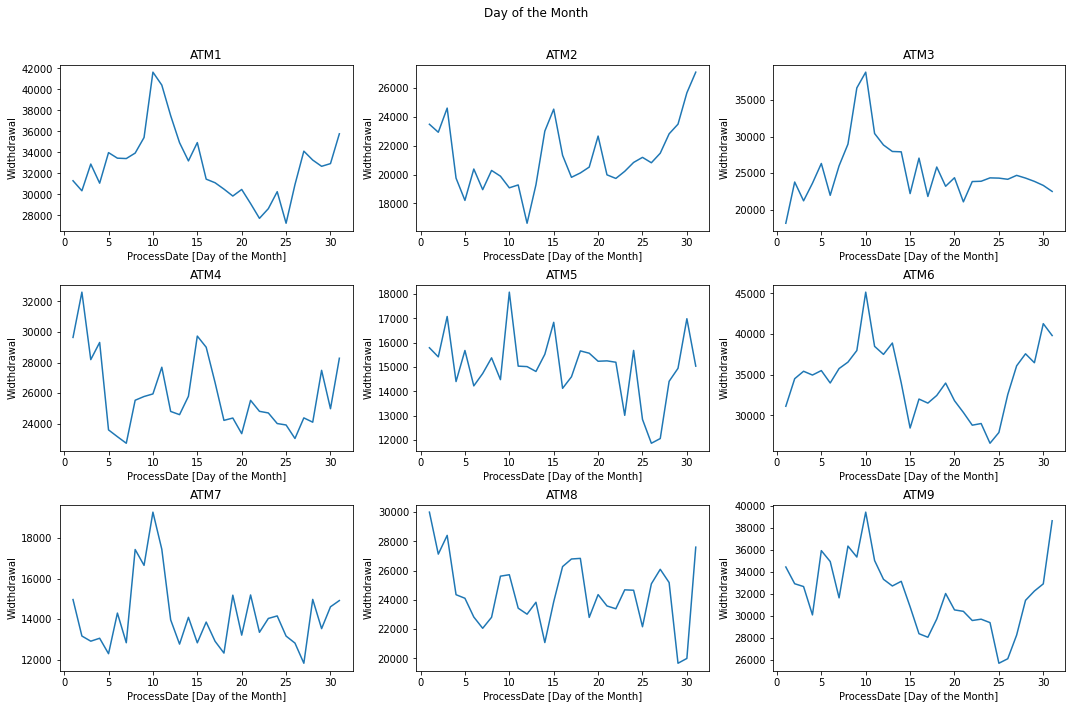

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(15,10))
fig.suptitle('Day of the Month')
for i, ax in zip(df, axs.ravel()):
    df.groupby(df.index.day).mean()[i].plot(ax=ax,title=i)
    ax.set_xlabel('ProcessDate [Day of the Month]')
    ax.set_ylabel('Widthdrawal')
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

###

ATM1, ATM3, ATM6, ATM 7 and ATM show monthly seasonality on 10th of each month; ATM 2 and ATM9 on 30th and ATM 4/ATM 8 on 1st.

###

In [139]:
import statsmodels.api as sm

In [144]:
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"{i}: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"{i}: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

for i in df:
    is_stationary(df[i])

ATM1: Stationary (H0: non-stationary, p-value: 0.0)
ATM2: Non-Stationary (H0: non-stationary, p-value: 0.101)
ATM3: Stationary (H0: non-stationary, p-value: 0.015)
ATM4: Stationary (H0: non-stationary, p-value: 0.004)
ATM5: Stationary (H0: non-stationary, p-value: 0.026)
ATM6: Stationary (H0: non-stationary, p-value: 0.0)
ATM7: Stationary (H0: non-stationary, p-value: 0.0)
ATM8: Stationary (H0: non-stationary, p-value: 0.017)
ATM9: Stationary (H0: non-stationary, p-value: 0.001)


# [3] Timeseries prediction

a) ExponentialSmoothing

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [49]:
#for i in df.columns:
#    results = seasonal_decompose(df[i][-365:],model='additive')
#    results.plot();

In [50]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [79]:
import warnings
warnings.filterwarnings('ignore')
import datetime

In [120]:
def fitting():
    fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(15,10))
    fig.suptitle('ExponentialSmoothing')
    score = []
    for i, ax in zip(df.columns, axs.ravel()):
        train = df[i].iloc[:-30]
        test = df[i].iloc[-30:]
        model = ExponentialSmoothing(
                    train,
                    trend='add',
                    seasonal='add',
                    seasonal_periods=7
                     ).fit()
        pred = model.forecast(60)
        ax.title.set_text(i)
        ax.tick_params(labelrotation=45)
        ax.plot(test)
        ax.plot(pred)
        MAE = mean_absolute_error(pred[0:30],test)
        MAPE = mean_absolute_percentage_error(pred[0:30],test)
        MSE = mean_squared_error(pred[0:30],test)
        RMSE = MSE**0.5
        score.append([i,MAE, MAPE,MSE,RMSE])
    fig.tight_layout()
    fig.legend( ['test', 'predictions'],loc='upper right')
    fig.subplots_adjust(top=0.90)
    fig.show()
    score_es = pd.DataFrame(score, columns=['ATM','Mean absolute error','Mean absolute percentage error','Mean squared error','Root-mean-square error'])
    return score_es
        

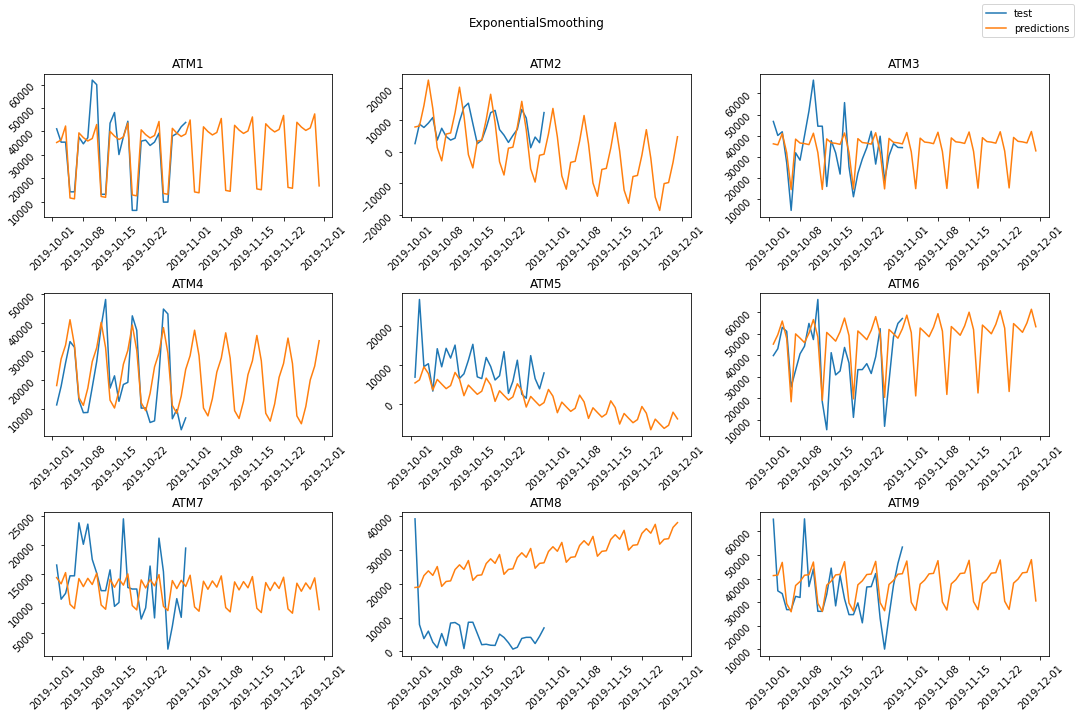

In [121]:
score_es = fitting()

###

ExponentialSmoothing show reasonable predictions for ATM1, ATM3,ATM4, ATM6. Weekly Seasonality is preserved.

Predictions for ATM 2 and ATM5 are bad since they go into negative values.

Predictions for ATM8 are also off, but that is mainly due to anomalies between 30th of September to 2nd of October 2019:

(2019-09-30    20500.0

2019-10-01    36400.0

2019-10-02    39200.0)

These dates show significantly higher withdrawals compared to nearby days.
###

In [54]:
score_es

,ATM,Mean absolute error,Mean absolute percentage error,Mean squared error,Root-mean-square error
0,ATM1,4702.575835,0.171101,4.721930e+07,6871.629916
1,ATM2,6089.810809,2.096774,6.066052e+07,7788.486296
2,ATM3,9017.711435,0.308200,1.346234e+08,11602.733930
3,ATM4,7208.721674,0.340680,7.610423e+07,8723.773691
4,ATM5,5531.747048,2.831430,4.819311e+07,6942.125611
5,ATM6,11389.928848,0.255119,2.095914e+08,14477.270389
6,ATM7,4748.377055,0.387380,2.930316e+07,5413.239319
7,ATM8,20277.800332,0.828120,4.286740e+08,20704.443065
8,ATM9,7805.848284,0.202889,1.021901e+08,10108.911173


In [55]:
score_es['Mean absolute error'].sum()

76772.52131953115

[Text(0.5, 1.0, 'ExponentialSmoothing')]

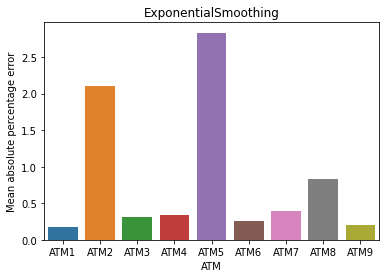

In [56]:
sns.barplot(data=score_es,x='ATM',y='Mean absolute percentage error').set(title='ExponentialSmoothing')

b) SARIMAX (Seasonal Auto-Regressive Integrated Moving Average)

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [58]:
#from pmdarima import auto_arima
#for i in df.columns:
#    print(auto_arima(df[i], seasonal=True,m=7).summary())

In [59]:
params = {
        'ATM1':[(2,0,3),(2,0,[1],7)],
        'ATM2': [(5,0,3),(2,0,[1,2],7)],
        'ATM3':[(5,1,0),(2,0,[1],7)],
        'ATM4':[(1,0,0),(2,0,[1],7)],
        'ATM5':[(3,0,3),(2,0,[1,2],7)],
        'ATM6': [(5, 1, 2),(1, 0, [1], 7)],
        'ATM7':[(2, 0, 3),(2, 0, [1], 7)],
        'ATM8':[(4, 1, 3),(1, 0, [1], 7)],
        'ATM9':[(0, 1, 2),(0, 0, 2, 7)]
          }

In [136]:
def fitting():
    fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(15,10))
    fig.suptitle('SARIMAX')
    score = []
    for i, ax in zip(df.columns, axs.ravel()):
        train = df[i].iloc[:-30]
        test = df[i].iloc[-30:]
        model = SARIMAX(train,order=params[i][0],seasonal_order=params[i][1]).fit()
        pred = model.forecast(60)
        ax.title.set_text(i)
        ax.tick_params(labelrotation=45)
        ax.plot(test)
        ax.plot(pred)
        MAE = mean_absolute_error(pred[0:30],test)
        MAPE = mean_absolute_percentage_error(pred[0:30],test)
        MSE = mean_squared_error(pred[0:30],test)
        RMSE = MSE**0.5
        score.append([i,MAE, MAPE,MSE,RMSE])
    fig.tight_layout()
    fig.legend( ['test', 'predictions'],loc='upper right')
    fig.subplots_adjust(top=0.90)
    fig.show()
    score_sarimax = pd.DataFrame(score, columns=['ATM','Mean absolute error','Mean absolute percentage error','Mean squared error','Root-mean-square error'])
    return score_sarimax

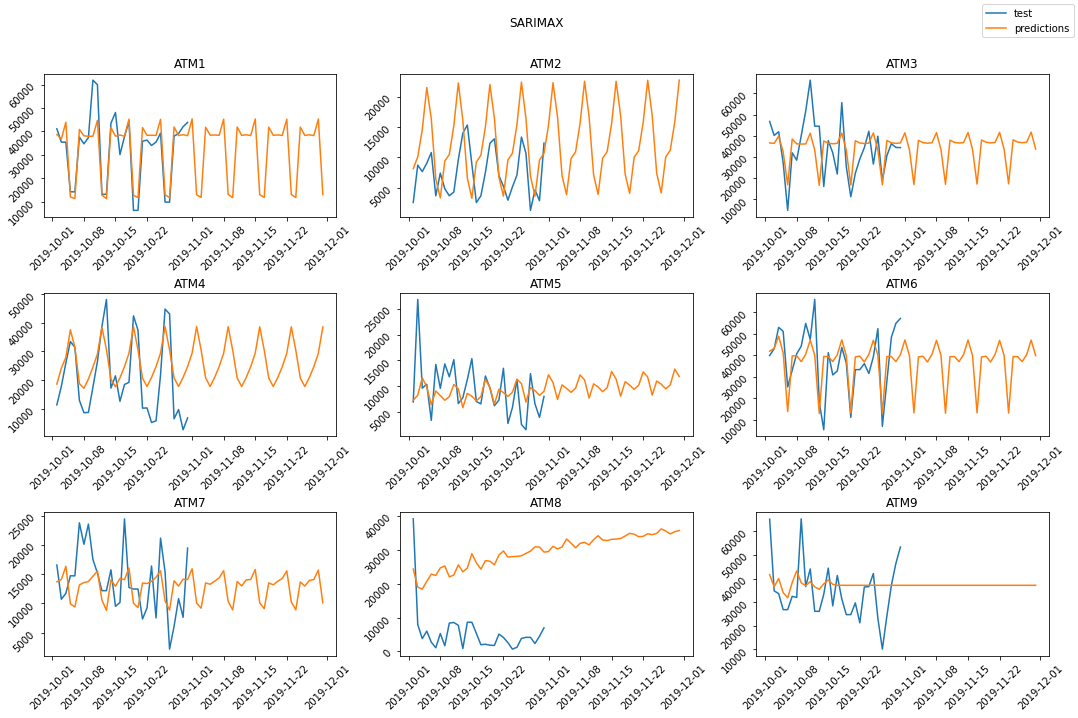

In [137]:
score_sarimax = fitting()

SARIMAX model showed best prediction for ATM1, ATM 3, ATM4 and ATM6. Seasonal patterns are visible in the models.

ATM8 is again completely wrong due to the anomalies on 30.09.2019-2.10.2019.

None the the model predict negative values.

In [62]:
score_sarimax

,ATM,Mean absolute error,Mean absolute percentage error,Mean squared error,Root-mean-square error
0,ATM1,4646.956324,0.162818,4.502815e+07,6710.301517
1,ATM2,5877.465950,0.567233,4.476751e+07,6690.852775
2,ATM3,8881.112815,0.291232,1.282744e+08,11325.830160
3,ATM4,8416.161666,0.361376,9.842417e+07,9920.895420
4,ATM5,3423.424148,0.407236,2.437545e+07,4937.149854
5,ATM6,8325.131123,0.249274,1.250607e+08,11183.052210
6,ATM7,4780.543349,0.377299,2.923566e+07,5407.000731
7,ATM8,21373.905387,0.820922,4.786636e+08,21878.381130
8,ATM9,9189.654201,0.243595,1.349992e+08,11618.913942


[Text(0.5, 1.0, 'SARIMAX')]

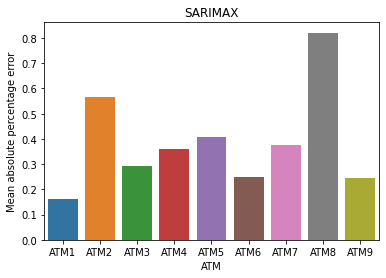

In [63]:
sns.barplot(data=score_sarimax,x='ATM',y='Mean absolute percentage error').set(title='SARIMAX')

c) Prophet

In [64]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
from prophet import Prophet

In [138]:
def fitting_prophet():
    fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(15,10))
    fig.suptitle('Prophet')
    score = []
    for i, ax in zip(df.columns, axs.ravel()):
        train = df[i].iloc[:-30].copy()
        test = df[i].iloc[-30:].copy()
        df_prophet = pd.DataFrame(columns=['ds','y'])
        df_prophet['ds'] =train.index
        df_prophet['y'] = train.values
        model = Prophet()
        model.fit(df_prophet)
        pred = model.make_future_dataframe(periods=60,freq='D')
        forecast = model.predict(pred)
        ax.title.set_text(i)
        ax.tick_params(labelrotation=45)
        ax.plot(test)
        ax.plot(forecast['ds'][-60:],forecast['yhat'][-60:])
        MAE = mean_absolute_error(forecast['yhat'][-60:-30],test)
        MAPE = mean_absolute_percentage_error(forecast['yhat'][-60:-30],test)
        MSE = mean_squared_error(forecast['yhat'][-60:-30],test)
        RMSE = MSE**0.5
        score.append([i,MAE, MAPE,MSE,RMSE])
    fig.tight_layout()
    fig.legend( ['test', 'predictions'],loc='upper right')
    fig.subplots_adjust(top=0.90)
    fig.show()
    score_prophet = pd.DataFrame(score, columns=['ATM','Mean absolute error','Mean absolute percentage error','Mean squared error','Root-mean-square error'])
    return score_prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfepvx4wm/b4yrz4ct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfepvx4wm/kb3vsp1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99897', 'data', 'file=/tmp/tmpfepvx4wm/b4yrz4ct.json', 'init=/tmp/tmpfepvx4wm/kb3vsp1q.json', 'output', 'file=/tmp/tmpfepvx4wm/prophet_modelxbnn1m_3/prophet_model-20230122205457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:54:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:54:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfep

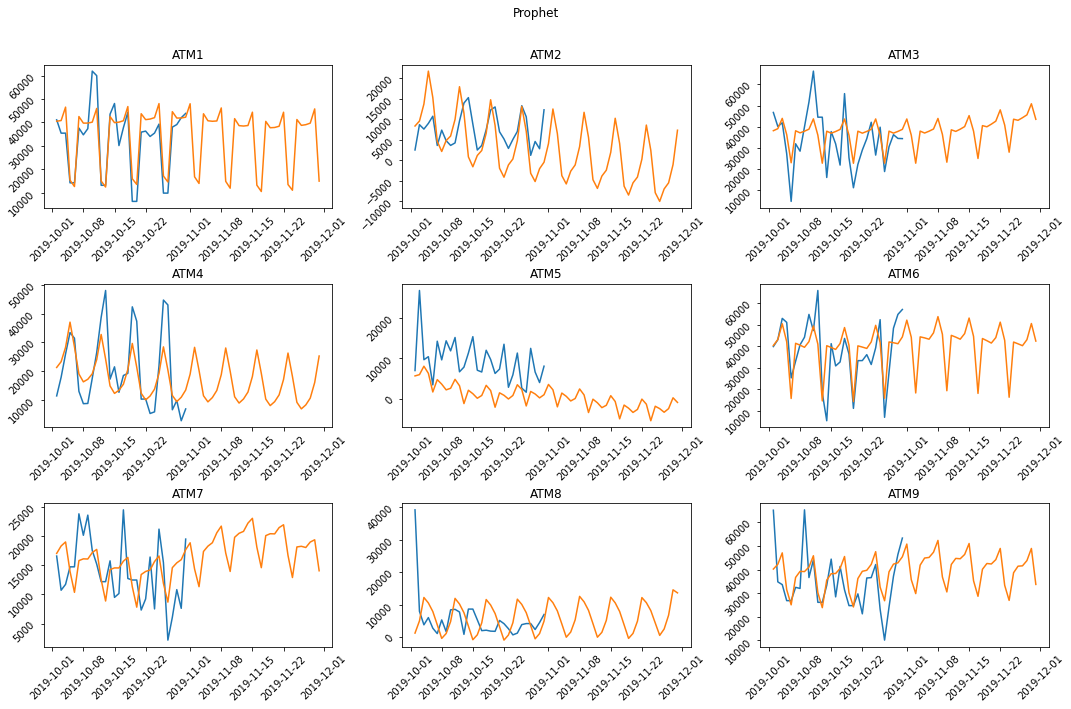

In [67]:
score_prophet = fitting_prophet()

Prophet showed best predictions out of the used models. ATM1,ATM2, ATM3, ATM4, ATM6 have retained proper seasonality and trend.

 Anomalies in the data in ATM8 did not affect the model.

In [68]:
score_prophet

,ATM,Mean absolute error,Mean absolute percentage error,Mean squared error,Root-mean-square error
0,ATM1,5698.076421,0.183258,5.369715e+07,7327.834182
1,ATM2,5174.203373,3.069694,4.229152e+07,6503.193280
2,ATM3,9082.851088,0.266904,1.256207e+08,11208.064058
3,ATM4,6798.858858,0.362454,8.287023e+07,9103.308517
4,ATM5,7172.466929,7.820213,6.988910e+07,8359.969849
5,ATM6,8235.098386,0.231224,1.190697e+08,10911.905359
6,ATM7,4471.385882,0.319636,2.700541e+07,5196.672537
7,ATM8,5677.825614,3.160120,7.465578e+07,8640.357734
8,ATM9,7933.272196,0.209779,1.059502e+08,10293.211633


[Text(0.5, 1.0, 'Prophet')]

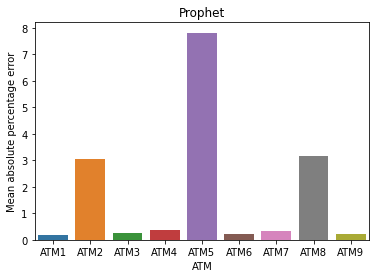

In [69]:
sns.barplot(data=score_prophet,x='ATM',y='Mean absolute percentage error').set(title='Prophet')

In [70]:
score_es['Mean absolute error'].sum()

76772.52131953115

In [71]:
score_prophet['Mean absolute error'].sum()

60244.03874738887

In [72]:
score_sarimax['Mean absolute error'].sum()

74914.35496240578

#[4] SQL QUARY

SELECT Atm, Withdrawal, Deposit 

FROM Atm_History 

WHERE ProcessDate 

IN (SELECT MAX(ProcessDate) 

FROM Atm_History 

GROUP BY Atm);

